# <span style="color:#ff5f27;">〽️ Sklearn Modeling </span>

---

## <span style="color:#ff5f27;"> 🔮 Connecting to Hopsworks Feature Store </span>

In [1]:
import hopsworks

project = hopsworks.login()

fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://2176a0f0-3503-11ed-be64-b1a4781e5f0a.cloud.hopsworks.ai/p/128
Connected. Call `.close()` to terminate connection gracefully.


## <span style="color:#ff5f27;"> 🪝 Feature View and Training Dataset Retrieval </span>

In [2]:
feature_view = fs.get_feature_view(
    name = 'titanic_fv',
    version = 1
)

In [3]:
X, y = feature_view.get_training_data(1)

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X.drop(columns=["passengerid"]), y, test_size=0.33, random_state=42)

In [5]:
X_train.head()

,sex,age,pclass,sibsp,parch,fare,embarked
6,1,0.428870,-0.369365,-0.474545,-0.473674,0.050749,2
718,0,-0.108755,0.827377,-0.474545,-0.473674,0.014102,1
685,1,-0.031952,0.827377,-0.474545,-0.473674,0.018543,2
73,0,-0.108755,0.827377,-0.474545,-0.473674,0.015282,0
882,1,0.582478,-0.369365,0.432793,-0.473674,0.050749,2


In [6]:
y_train.head()

,survived
6,0
718,1
685,0
73,1
882,0


---

## <span style="color:#ff5f27;"> 🤖 Modeling</span>

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

In [8]:
import warnings

# Mute warnings
warnings.filterwarnings("ignore")

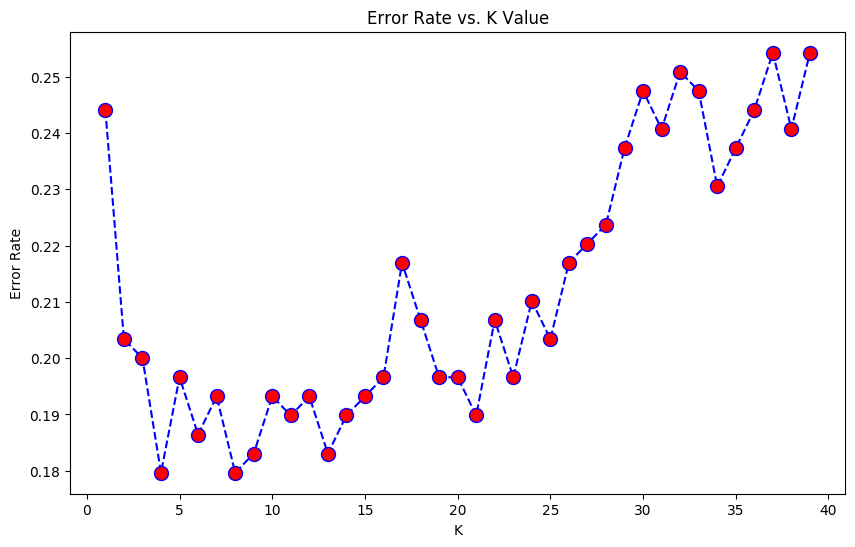

Minimum error:- 0.17966101694915254 at K = 3


In [9]:
error_rate = []
for i in range(1,40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test.values.ravel()))

plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.show()
print("Minimum error:-",min(error_rate),"at K =",error_rate.index(min(error_rate)))

In [10]:
knn_final = KNeighborsClassifier(n_neighbors=26)
knn_final.fit(X_train, y_train)
preds = knn_final.predict(X_test)

f1_score(preds, y_test)

0.6595744680851064

#### Very poor result from KNN.

In [11]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

preds = rf.predict(X_test)

f1_score(preds, y_test)

0.766355140186916

#### Much better from Random Forest

In [12]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)

preds = gb.predict(X_test)

f1_score(preds, y_test)

0.7881773399014778

#### We will use this GradientBoostingClassifier model to register on Model Registry and make a deployment.

---

## <span style="color:#ff5f27;"> 📝 Register model in Hopsworks</span>

In [13]:
mr = project.get_model_registry()

Connected. Call `.close()` to terminate connection gracefully.


In [14]:
import joblib

joblib.dump(gb, 'model.pkl')

['model.pkl']

In [15]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

model_schema.to_dict()

{'input_schema': {'columnar_schema': [{'name': 'sex', 'type': 'int64'},
   {'name': 'age', 'type': 'float64'},
   {'name': 'pclass', 'type': 'float64'},
   {'name': 'sibsp', 'type': 'float64'},
   {'name': 'parch', 'type': 'float64'},
   {'name': 'fare', 'type': 'float64'},
   {'name': 'embarked', 'type': 'int64'}]},
 'output_schema': {'columnar_schema': [{'name': 'survived', 'type': 'int64'}]}}

In [16]:
metrics = {
    'f1_score': f1_score(preds, y_test)
}

In [17]:
model = mr.sklearn.create_model(
    name="titanic_gradient_boosting_model",
    metrics=metrics,
    description="GradientBoostingClassifier.",
    input_example=X_test.sample(),
    model_schema=model_schema
)

model.save('model.pkl')

  0%|          | 0/6 [00:00<?, ?it/s]

Model created, explore it at https://2176a0f0-3503-11ed-be64-b1a4781e5f0a.cloud.hopsworks.ai/p/128/models/titanic_gradient_boosting_model/3


Model(name: 'titanic_gradient_boosting_model', version: 3)

## <span style="color:#ff5f27;"> 🚀 Deployment</span>

In [18]:
# feature_view.get_feature_vector({"passengerid": 2})

In [19]:
# feature_view.get_feature_vector({"passengerid": data["inputs"][0]})

## !! We have a problem with online-enabled Featre Groups (already reported on Jira), so we cannot proceed with Deployments.

In [20]:
%%writefile predict_example.py
import os
import numpy as np
import hopsworks
import joblib

class Predict(object):

    def __init__(self):
        """ Initializes the serving state, reads a trained model"""        
        # get feature store handle
#         project = hopsworks.login()
#         self.fs = project.get_feature_store()
        
#         # get feature views
#         self.fv = self.fs.get_feature_view("titanic_fv", 1)
        
#         # initialise serving
#         self.fv.init_serving(1)

        # load the trained model
        self.model = joblib.load(os.environ["ARTIFACT_FILES_PATH"] + "/model.pkl")
        print("Initialization Complete")

    def predict(self, inputs):
        """ Serves a prediction request usign a trained model"""
#         feature_vector = self.fv.get_feature_vector({"passengerid": inputs[0]})
        
        
        return self.model.predict(inputs).tolist() # Numpy Arrays are not JSON serializable

Overwriting predict_example.py


In [21]:
import os
dataset_api = project.get_dataset_api()

uploaded_file_path = dataset_api.upload("predict_example.py", "Models", overwrite=True)

predictor_script_path = os.path.join("/Projects", project.name, uploaded_file_path)

Uploading: 0.000%|          | 0/928 elapsed<00:00 remaining<?

In [22]:
predictor_script_path

'/Projects/Model_Serving/Models/predict_example.py'

In [24]:
model = mr.get_model("titanic_gradient_boosting_model", version=3)

In [25]:
# Give it any name you want
deployment = model.deploy(
    name="titanicgradientboostingdeployment", 
    model_server="PYTHON",
    script_file=predictor_script_path,
    serving_tool = "KSERVE"
)

Deployment created, explore it at https://2176a0f0-3503-11ed-be64-b1a4781e5f0a.cloud.hopsworks.ai/p/128/deployments/15
Before making predictions, start the deployment by using `.start()`


In [26]:
print("Deployment: " + deployment.name)
deployment.describe()

Deployment: titanicgradientboostingdeployment
{
    "artifact_version": 1,
    "batching_configuration": {
        "batching_enabled": false
    },
    "created": "2022-09-16T14:16:49.155Z",
    "creator": "Roman Kaharlytskyi",
    "id": 15,
    "inference_logging": "NONE",
    "model_name": "titanic_gradient_boosting_model",
    "model_path": "/Projects/Model_Serving/Models/titanic_gradient_boosting_model",
    "model_server": "PYTHON",
    "model_version": 3,
    "name": "titanicgradientboostingdeployment",
    "predictor": "predict_example.py",
    "predictor_resources": {
        "limits": {
            "cores": 0.5,
            "gpus": 0,
            "memory": 1024
        },
        "requests": {
            "cores": 0.2,
            "gpus": 0,
            "memory": 32
        }
    },
    "requested_instances": 0,
    "serving_tool": "KSERVE"
}


In [27]:
deployment.start()

0it [00:00, ?it/s]

Start making predictions by using `.predict()`


In [28]:
deployment.get_logs()

Explore all the logs and filters in the Kibana logs at https://2176a0f0-3503-11ed-be64-b1a4781e5f0a.cloud.hopsworks.ai/p/128/deployments/15

Instance name: titanicgradientboost66d21ca59e3ec269365e7efa689bcfbf-deplodfzmr
[I 220916 14:17:02 kserve-component-server:95] Initializing predictor for deployment: titanicgradientboostingdeployment
[I 220916 14:17:02 kfserver:150] Registering model: titanicgradientboostingdeployment
[I 220916 14:17:02 kfserver:120] Setting asyncio max_workers as 12
[I 220916 14:17:02 kfserver:127] Listening on port 8080
[I 220916 14:17:02 kfserver:129] Will fork 1 workers




In [37]:
test = np.array(model.input_example)

In [47]:
data = {
    "inputs": test.reshape(-1, 1).tolist()
}

data

{'inputs': [[1.0],
  [-0.4927734154492689],
  [0.8273772438659698],
  [-0.4745451962498396],
  [-0.4736736092984606],
  [0.0153303774213923],
  [2.0]]}

In [48]:
deployment.predict(data)

RestAPIError: Metadata operation error: (url: http://172.16.4.41:32080/v1/models/titanicgradientboostingdeployment:predict). Server response: 
HTTP code: 500, HTTP reason: Internal Server Error

 Check the model server logs by using `.get_logs()`

In [49]:
deployment.get_logs(tail=20)

Explore all the logs and filters in the Kibana logs at https://2176a0f0-3503-11ed-be64-b1a4781e5f0a.cloud.hopsworks.ai/p/128/deployments/15

Instance name: titanicgradientboost66d21ca59e3ec269365e7efa689bcfbf-deploz2dx2
[I 220916 14:27:42 kserve-component-server:95] Initializing predictor for deployment: titanicgradientboostingdeployment
[I 220916 14:27:42 kfserver:150] Registering model: titanicgradientboostingdeployment
[I 220916 14:27:42 kfserver:120] Setting asyncio max_workers as 12
[I 220916 14:27:42 kfserver:127] Listening on port 8080
[I 220916 14:27:42 kfserver:129] Will fork 1 workers
[E 220916 14:27:42 web:2246] 500 POST /v1/models/titanicgradientboostingdeployment:predict (127.0.0.1) 2.06ms


